# Terrain Classification - New Data
### Created by Keenan McConkey 2019.5.25

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names - Convention is different for older datasets
frame_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time']
std_columns =   ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

# Columns not currently used for classification - Mostly for phone data
unused_columns = ('LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)',
                  'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)')

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # New naming scheme
    if 'Phone' in _label or 'Wheel' in _label or 'Module' in _label:
        columns = std_columns.copy()
    # Old frame data naming scheme
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Middle']
transforms = ['FFT', 'PSDLog', 'PSD']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_paths = glob.glob('imu_data/set_upgraded_kevin/*.csv')

In [5]:
# Import datasets as an array of Pandas DataFrames
TRIM_START = 3600 # Number of data points to trim from each side (1s = 300 data points for frame)
TRIM_END = 3600
TRIM_OFFSET = 300 # Difference between startup of wheels and frame (1s)
N_DATA_COL = 6 # Number of columns containing directional data

dataset_labels = []

for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    for to_remove in unused_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f",))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Frame and Middle Phone data
    ## Can't remove from wheel-mounted devices because they rotate over time
    if 'Middle' in dataset_label:
        # Calculate gravity from last 2000 datapoints and subtract from Z Zccel
        ## We need to calculate it manually because device may not be exactly parallel to terrain
        #g_z = dataset.loc[-2000:]['Z Accel'].mean()

        # Using direct 9.81 instead if we assume calibrated to flat surface
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Trim edges to account for start and end time of 10 s plus some offest
    # Wheels start up about 1 s after the frame module
    if 'Middle' in dataset_label:
        dataset = dataset[TRIM_START + TRIM_OFFSET : -TRIM_END]
    else:
        dataset = dataset[TRIM_START : -TRIM_END]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
dataset_labels

['Middle_GrassPowerStraightKevin_Module6050',
 'Middle_ConcretePowerDonutKevin_Module6050',
 'Middle_SidewalkPowerStraightKevin_Module6050',
 'Middle_SidewalkPowerF8Kevin_Module6050',
 'Middle_SidewalkPowerDonutKevin_Module6050',
 'Middle_CarpetPowerDonutKevin_Module6050',
 'Middle_ConcretePowerF8Kevin_Module6050',
 'Middle_CarpetPowerStraightKevin_Module6050',
 'Middle_GravelPowerF8Kevin_Module6050',
 'Middle_AsphaltPowerF8Kevin_Module6050',
 'Middle_AsphaltPowerStraightKevin_Module6050',
 'Middle_GrassPowerDonutKevin_Module6050',
 'Middle_AsphaltPowerDonutKevin_Module6050',
 'Middle_LinoleumPowerStraightKevin_Module6050',
 'Middle_GrassPowerF8Kevin_Module6050',
 'Middle_ConcretePowerStraightKevin_Module6050',
 'Middle_GravelPowerStraightKevin_Module6050',
 'Middle_LinoleumPowerDonutKevin_Module6050',
 'Middle_CarpetPowerF8Kevin_Module6050',
 'Middle_LinoleumPowerF8Kevin_Module6050',
 'Middle_GravelPowerDonutKevin_Module6050']

In [7]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
3900,2.149870,-4.127450,3.627738,-0.278050,-0.319840,0.299658,13.019952,1.564176e+09
3901,3.809431,-1.229802,3.172736,-0.206660,-0.328098,0.283143,13.023442,1.564176e+09
3902,-2.639630,0.913499,3.469684,0.083429,-0.508438,0.209621,13.026488,1.564176e+09
3903,4.889463,-0.947222,2.621943,-0.085190,-0.673860,0.304720,13.029975,1.564176e+09
3904,-3.992663,-0.305429,0.375668,0.303726,-0.584356,0.058317,13.033463,1.564176e+09


### Part (b) - Visualizing Time Domain Data

In [8]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, y_column, x_column, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_column], _datasets[dataset_name][y_column])
    plt.title(dataset_name)
    plt.xlabel(x_column + ' (s)')
    
    if 'Accel' in y_column:
        plt.ylabel(y_column + ' ($m/s^2$)')
    elif 'Gyro' in y_column:
        plt.ylabel(y_column + ' ($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig is True:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_column.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

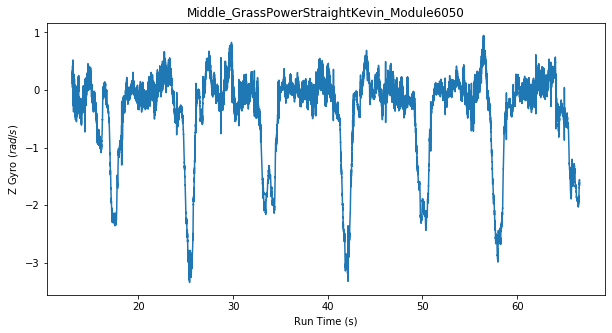

In [9]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Z Gyro', 'Run Time')

In [10]:
#Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(label, 'Z Gyro', 'Run Time', save_fig=True)

In [11]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [12]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_Concrete_Module',
#                raw_datasets, 'Right_Concrete_Module', 
#                dirn='Z Gyro')

In [13]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

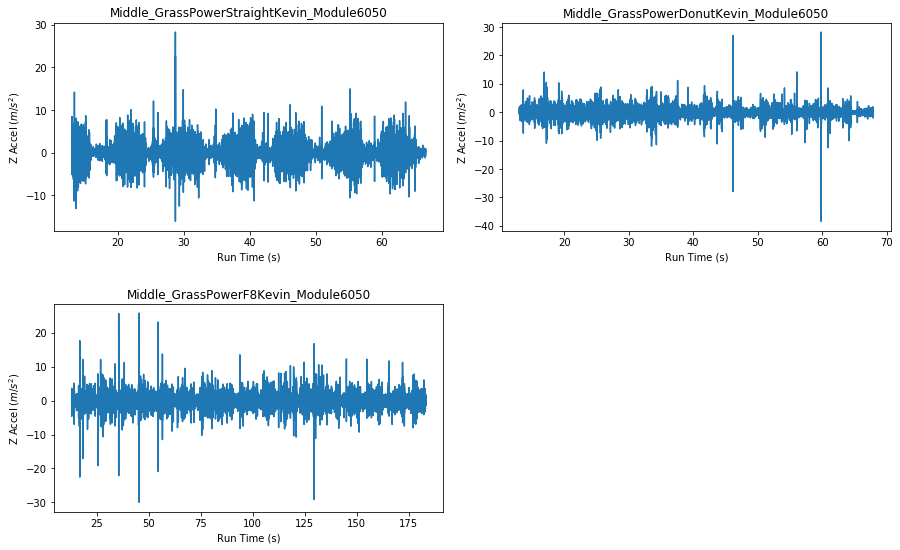

In [14]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Grass' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [15]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [16]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [17]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [18]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [19]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 21
Shape of first dataset: (16061, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Filtering

**Nominally set to 30 % of Nyquist Freq**

In [20]:
'''Get frequencies for given label'''
def get_frequencies(label):
    # Sampling frequency varies for different devices (old datasets only)
    if ('Left' in label or 'Right' in label): # Old naming convention used 'Frame'
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    else:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
        
    return f_samp, f_low, f_high

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

In [21]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

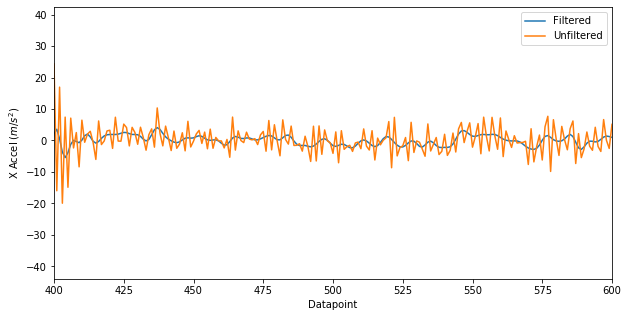

In [22]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(400, 600)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.show()

In [23]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 21
Shape of first filtered dataset: (16061, 8)


In [24]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,2.149788,-4.128483,3.625809,-0.277936,-0.320031,0.299630,13.019952,1.564176e+09
1,1.476567,-1.543801,3.697788,-0.134542,-0.399968,0.275116,13.023442,1.564176e+09
2,1.035239,-0.077580,3.369542,-0.020561,-0.500429,0.246980,13.026488,1.564176e+09
3,0.822468,0.060645,2.319528,0.048313,-0.606099,0.216003,13.029975,1.564176e+09
4,0.518180,-0.447585,0.510608,0.077533,-0.667371,0.188568,13.033463,1.564176e+09


<Figure size 432x288 with 0 Axes>

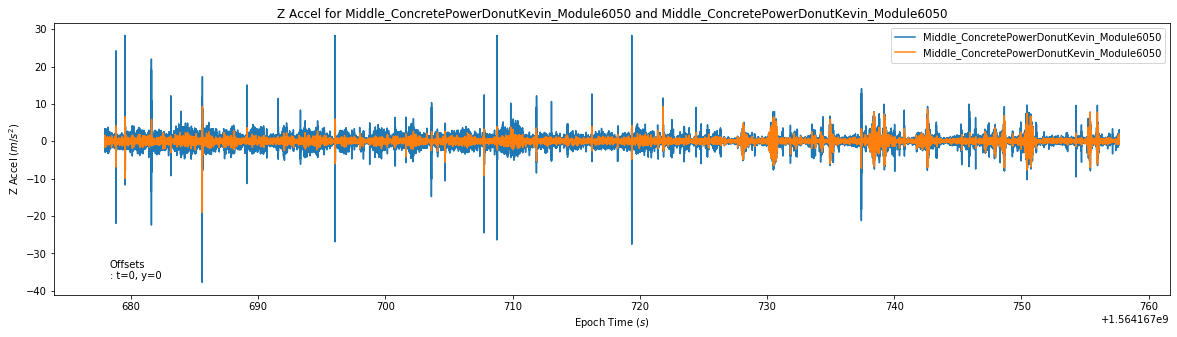

In [25]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[1], 
                np_to_pd(datasets), dataset_labels[1], 'Z Accel')

<Figure size 432x288 with 0 Axes>

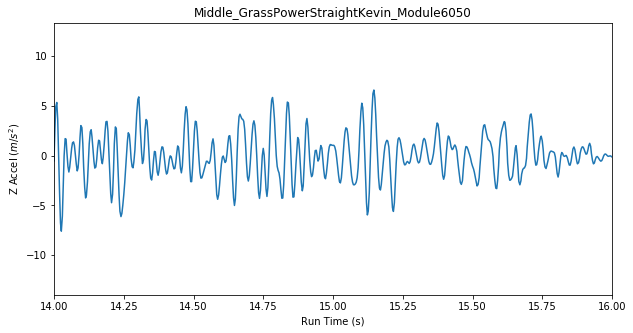

In [26]:
# Test plot single filtered data
plot_one(np_to_pd(datasets), dataset_labels[0], 'Z Accel', 'Run Time', xlim=(14, 16))

### Part (b) - Further Time Domain Visualization

In [27]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [28]:
#gyro_compare(np_to_pd(datasets), 'ConcretePower_Module6050', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [29]:
WINDOW_SIZE = 300 # Divide by F_SAMP to get window size in seconds
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [30]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 21
Num of windows in first dataset: 53
Shape of individual window: (300, 8)


In [31]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,-1.095174,-0.256786,2.638760,0.088373,0.574540,-0.327204,14.003268,1.564176e+09
296,1.114395,-1.520009,4.874989,0.123057,0.190323,-0.335817,14.006228,1.564176e+09
297,2.553433,-2.827487,5.343128,0.094462,-0.262275,-0.334564,14.009989,1.564176e+09
298,1.987023,-3.437237,3.654168,0.058588,-0.584960,-0.338916,14.013291,1.564176e+09
299,-0.272266,-3.043756,0.196491,0.059076,-0.654407,-0.352653,14.016277,1.564176e+09


<Figure size 432x288 with 0 Axes>

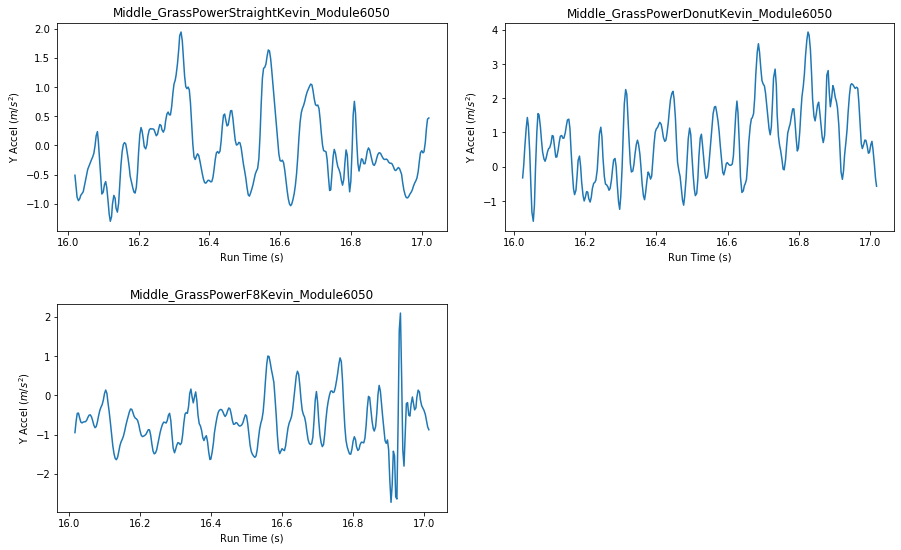

In [32]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Grass' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Y Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [33]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.show()

### Part (a) - FFT

In [34]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 10 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        n_bins = int(WINDOW_SIZE / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(WINDOW_SIZE, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + '_FFT': dataset_fft})

In [35]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'_FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'_FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'_FFT'][0].head()

Num of FFT'd windowed datasets: 21
Num of FFT'd windows in first dataset: 53
Shape of FFT'd individual window: (65, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.187885,0.459239,0.138092,0.022477,0.001497,0.139581,0.0
1,0.133075,0.184289,0.177391,0.010986,0.032836,0.037249,1.0
2,0.376988,0.216283,0.098958,0.014263,0.066546,0.099434,2.0
3,0.170682,0.120289,0.090957,0.016982,0.059887,0.023675,3.0
4,0.274861,0.053371,0.061734,0.028469,0.012905,0.015892,4.0


<Figure size 432x288 with 0 Axes>

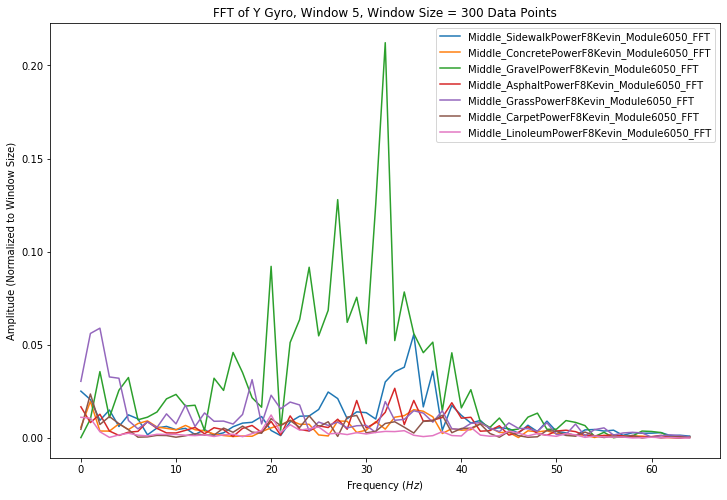

In [36]:
# Plot Z Accel of 0th window, Frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=5, dirn=4, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

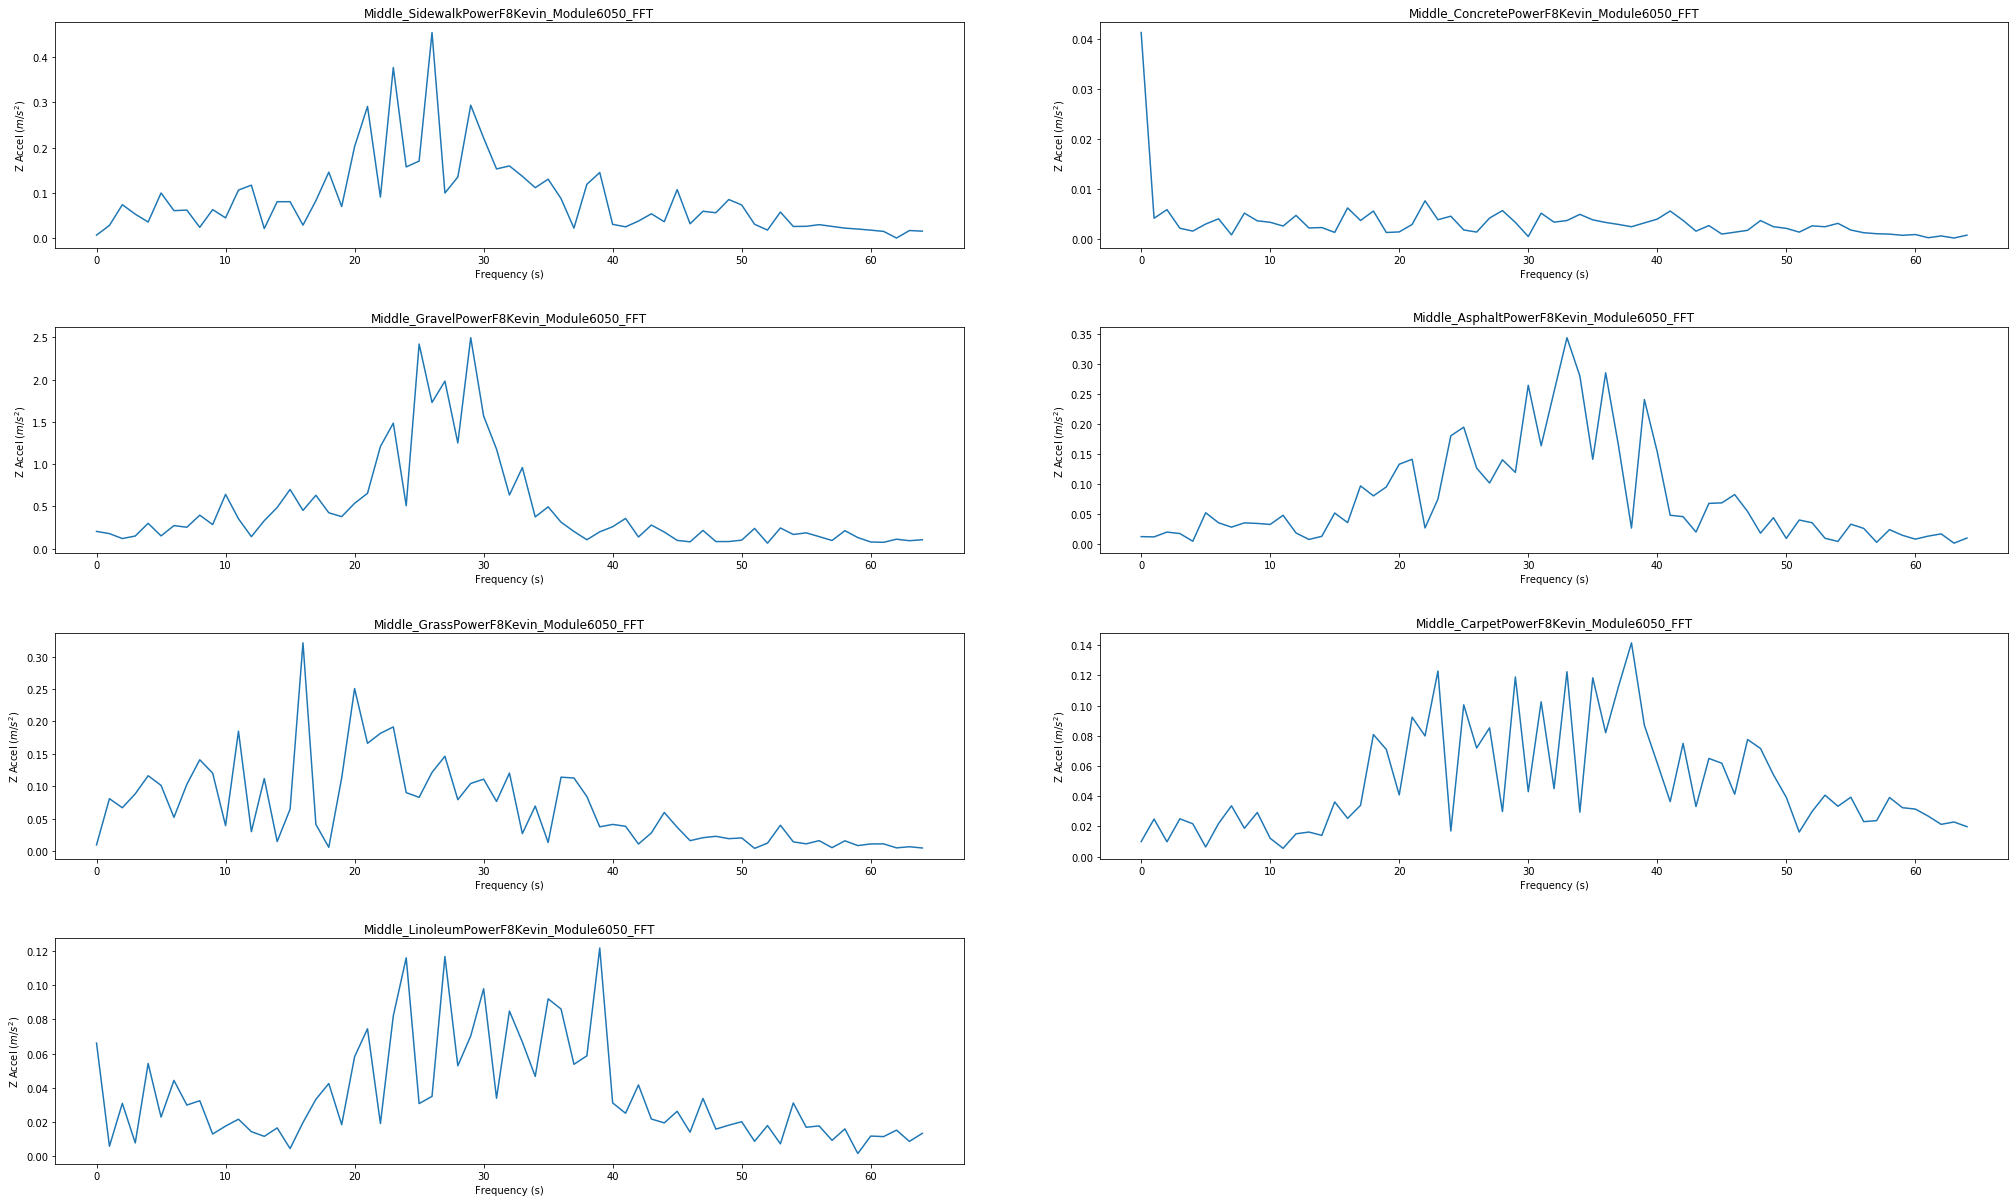

In [37]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [38]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        n_bins = int(WINDOW_SIZE / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        # Calculate PSD for each axes
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + '_PSD': dataset_psd})
    datasets_psd_log.update({label +'_PSDLog': dataset_psd_log})

In [39]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'_PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'_PSD'][0].shape))

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
Num PSD'd windowed datasets: 21
Num of PSD'd windows in first dataset: 53
Shape of PSD'd individual window: (65, 7)


<Figure size 432x288 with 0 Axes>

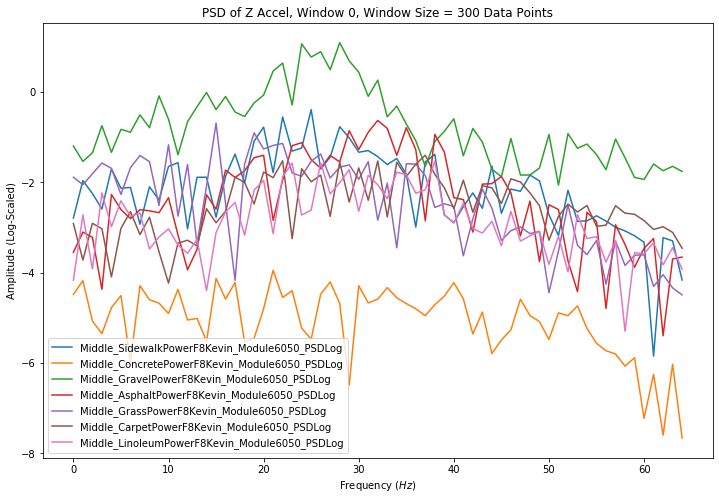

In [40]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

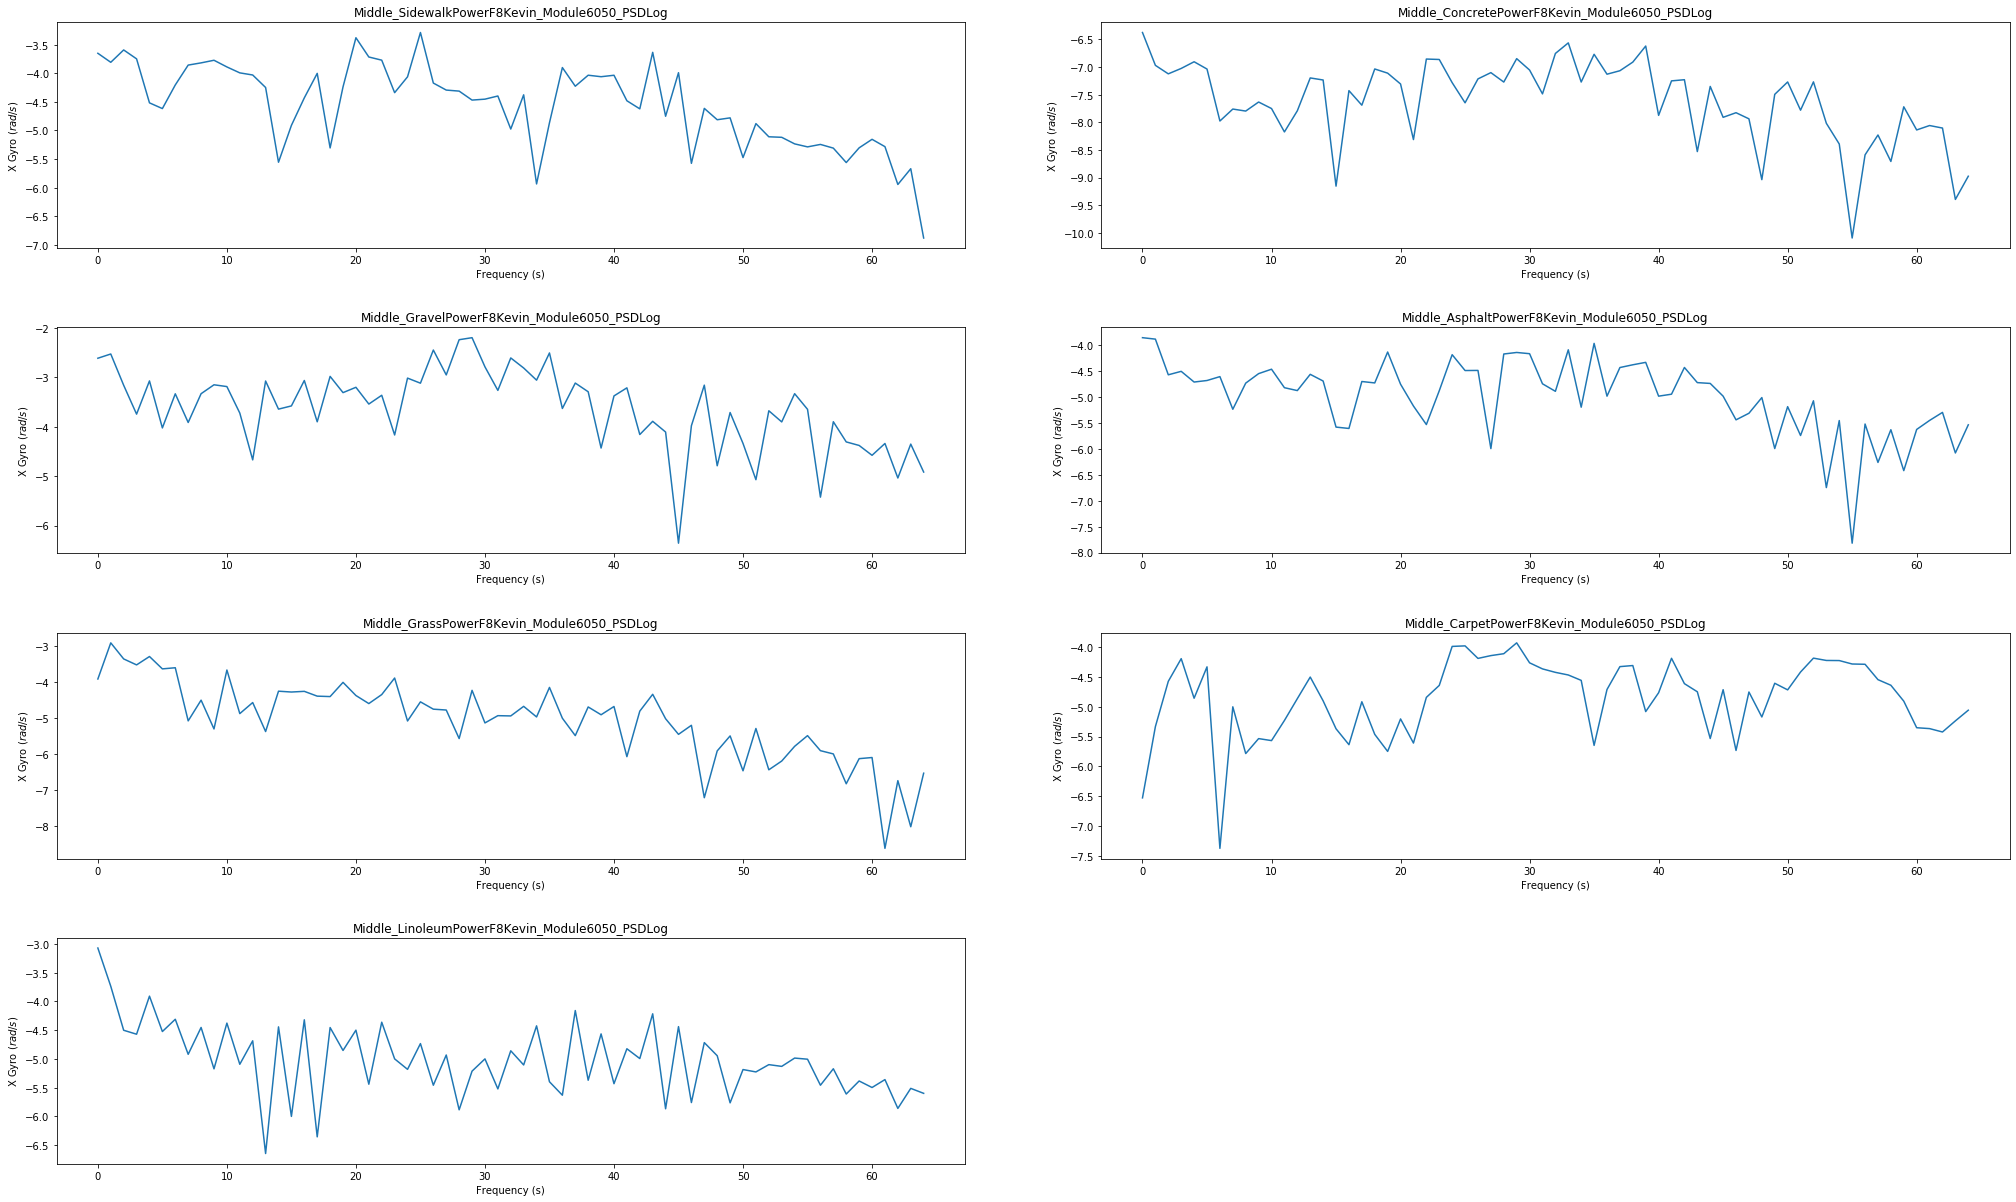

In [41]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [42]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

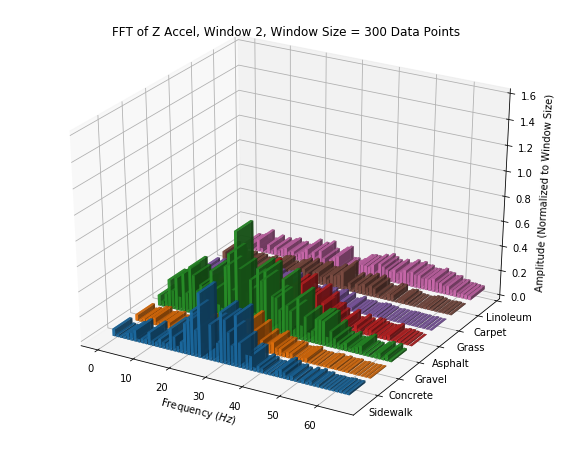

In [43]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=2, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

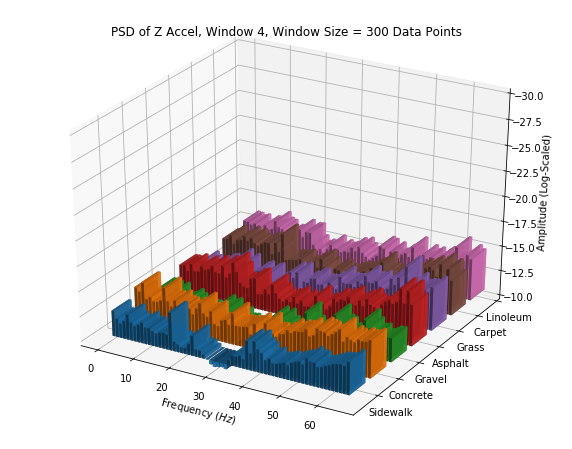

In [44]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(psds_to_plot, win_num=4, dirn=2, transform_name='PSD')

### Part (d) - Spectograms

In [45]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

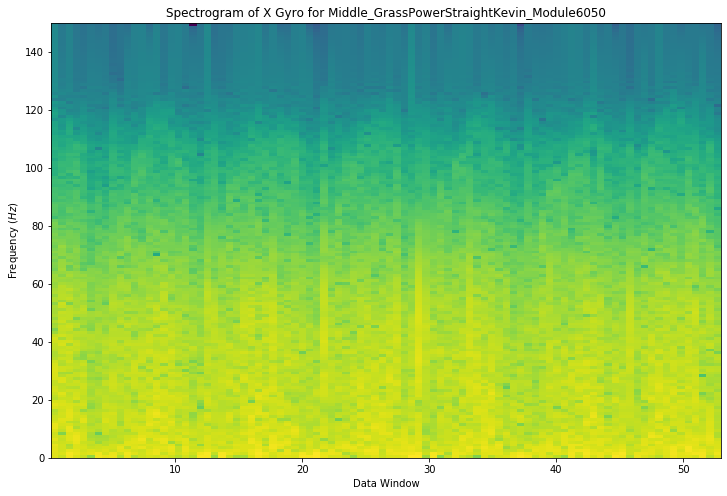

In [46]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=3, size=WINDOW_SIZE)

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [47]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [48]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('_PSD', ''): directions})
    
    return datasets_feat

In [49]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [50]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [51]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 21
Num directions: 6
Shape of first dataset first direction: (53, 10)


<Figure size 432x288 with 0 Axes>

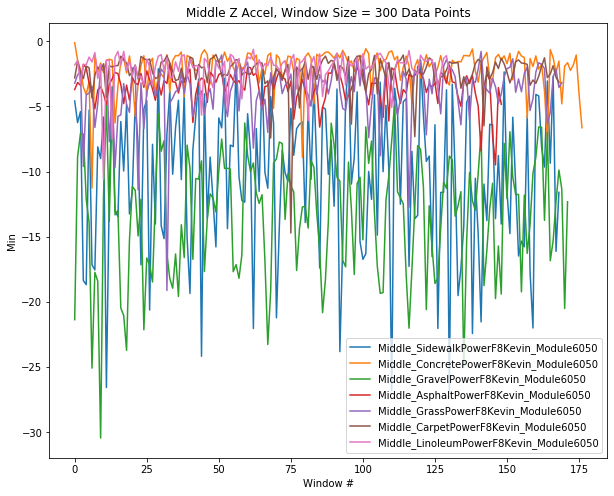

In [52]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [53]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [54]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 21
Num directions: 6
Shape of one direction: (53, 5)


<Figure size 432x288 with 0 Axes>

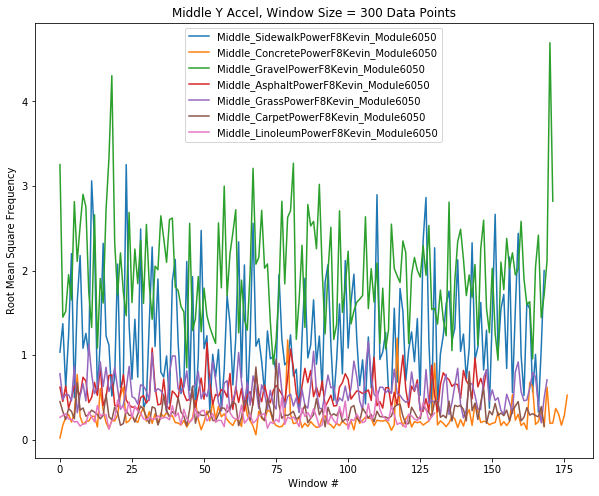

In [55]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [56]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [57]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [58]:
# Add time and freq features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [59]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Y Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-0.459239,1.694569,30.409529,924.739449,3.716060,-5.038676,1.755695,0.160000,-0.210315,-0.151798,2.065950,1.437341,18.259502,-331.343474,1.437341
1,-0.125793,1.364861,23.740274,563.600597,4.190346,-2.907760,1.370645,0.156667,0.384694,0.185540,0.924677,0.961601,15.862104,-250.681650,0.961601
2,-0.341556,1.102779,19.995866,399.834672,2.935861,-2.924147,1.154462,0.110000,0.085365,-0.022712,0.899600,0.948472,14.327438,-204.375874,0.948472
3,-0.070783,0.644277,11.226342,126.030745,1.941546,-1.298310,0.648153,0.056667,0.794265,0.270328,0.229631,0.479198,7.446126,-55.215165,0.479198
4,0.425846,0.946914,17.983248,323.397226,3.269380,-1.574448,1.038263,0.110000,0.343725,0.106182,0.689749,0.830512,12.877594,-165.142674,0.830512


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [60]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [61]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [62]:
datasets_feat_norm[dataset_labels[0]]['Y Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-1.489406,2.542944,2.656429,3.322023,0.585696,-2.126163,2.656429,1.430329,-0.678865,-0.630073,3.190578,2.432242,0.653558,-0.568900,2.432242
1,-0.321655,1.333828,1.221758,1.242578,1.003288,0.068169,1.221758,1.317688,0.664486,-0.439779,0.514892,0.624114,-0.033429,0.142004,0.624114
2,-1.077271,0.372716,0.416272,0.299610,-0.101242,0.051294,0.416272,-0.259287,-0.011307,-0.557255,0.456099,0.574215,-0.473195,0.550116,0.574215
3,-0.129006,-1.308718,-1.470202,-1.276959,-0.976702,1.725515,-1.470202,-2.061545,1.589173,-0.391950,-1.114626,-1.209337,-2.445069,1.864728,-1.209337
4,1.610222,-0.198877,-0.016676,-0.140518,0.192410,1.441159,-0.016676,-0.259287,0.571991,-0.484545,-0.035890,0.125886,-0.888655,0.895893,0.125886


<Figure size 432x288 with 0 Axes>

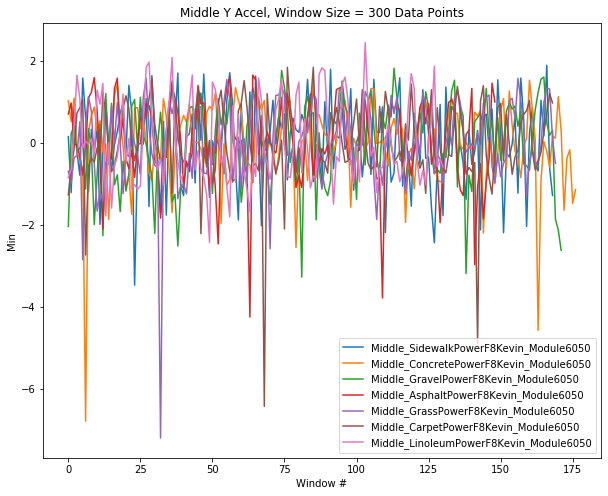

In [63]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

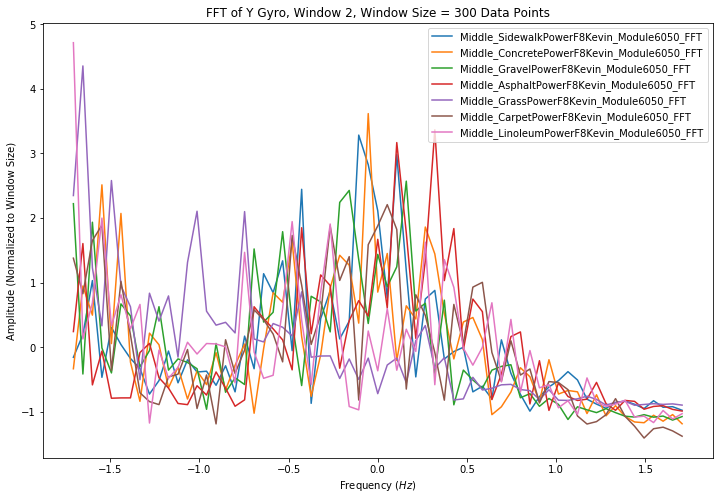

In [64]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=4, win_num=2, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [65]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [66]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [67]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,Excess Kurtosis X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,-0.302225,0.934093,0.330742,0.262315,-0.414931,-0.282276,0.330742,0.507642,-0.045709,-0.918661,...,0.430801,-0.498701,0.571305,1.092069,0.137806,1.521449,1.599445,0.992308,-0.773183,1.599445
1,-0.194640,0.174175,-0.549717,-0.594283,-0.383459,-2.387923,-0.549717,0.996824,-1.403346,0.765188,...,0.516049,-0.555077,-0.346246,-0.461765,-0.895502,-0.628901,-0.697634,0.072617,0.190343,-0.697634
2,-1.482808,0.955410,1.529654,1.609918,0.125676,-0.324614,1.529654,-0.796844,1.228873,-0.152184,...,-0.143779,0.012406,-0.805021,-0.412615,-1.165164,-0.454595,-0.366212,-0.457933,0.555574,-0.366212
3,-0.992113,-2.323547,-2.366685,-2.005808,-2.109192,1.019213,-2.366685,-1.204496,-1.233457,-0.985119,...,-0.417662,-0.052827,-0.116858,-1.329605,-0.377418,-0.374354,-0.237209,-1.251041,0.839965,-0.237209
4,-0.052561,-1.517807,-2.468251,-2.070549,-1.124128,1.090525,-2.468251,-0.307662,-0.745328,-0.774553,...,-1.527732,2.078927,-1.034409,1.220387,-0.581574,-0.244250,-0.048207,-1.289719,0.845913,-0.048207


#### Part (ii) - Transformed Data

In [68]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency'], 1))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [69]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [70]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [71]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + '_FFT'].tail()

,FFT 64.0 Hz Z Gyro Middle,FFT 64.0 Hz Y Gyro Middle,FFT 64.0 Hz X Gyro Middle,FFT 64.0 Hz Z Accel Middle,FFT 64.0 Hz Y Accel Middle,FFT 64.0 Hz X Accel Middle,FFT 63.0 Hz Z Gyro Middle,FFT 63.0 Hz Y Gyro Middle,FFT 63.0 Hz X Gyro Middle,FFT 63.0 Hz Z Accel Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
48,0.000970,0.002083,0.002505,0.027921,0.049825,0.034687,0.000802,0.002002,0.000225,0.009950,...,0.011001,0.030943,0.063141,0.059523,0.060677,0.022123,0.024144,0.045188,0.218368,0.255377
49,0.000268,0.001547,0.000301,0.009904,0.006277,0.007402,0.000382,0.000786,0.000939,0.006265,...,0.029733,0.043640,0.128580,0.246309,0.141738,0.013250,0.022721,0.025649,0.239207,0.112598
50,0.000411,0.002792,0.000618,0.009233,0.007473,0.012774,0.000446,0.002363,0.000990,0.006550,...,0.010941,0.022560,0.073416,0.296603,0.241809,0.005755,0.021070,0.007061,0.391034,0.558142
51,0.002197,0.000634,0.000791,0.009535,0.014308,0.012058,0.002234,0.000828,0.000964,0.006573,...,0.036932,0.079597,0.174641,0.374077,0.382821,0.012478,0.077358,0.064522,0.644042,0.065291
52,0.002385,0.000549,0.000137,0.003490,0.006004,0.001793,0.002430,0.000772,0.000722,0.003111,...,0.031604,0.013863,0.199750,0.429075,1.130302,0.032646,0.011519,0.035769,0.296043,1.329075


In [72]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].tail()

,PSDLog 64.0 Hz Z Gyro Middle,PSDLog 64.0 Hz Y Gyro Middle,PSDLog 64.0 Hz X Gyro Middle,PSDLog 64.0 Hz Z Accel Middle,PSDLog 64.0 Hz Y Accel Middle,PSDLog 64.0 Hz X Accel Middle,PSDLog 63.0 Hz Z Gyro Middle,PSDLog 63.0 Hz Y Gyro Middle,PSDLog 63.0 Hz X Gyro Middle,PSDLog 63.0 Hz Z Accel Middle,...,PSDLog 1.0 Hz X Gyro Middle,PSDLog 1.0 Hz Z Accel Middle,PSDLog 1.0 Hz Y Accel Middle,PSDLog 1.0 Hz X Accel Middle,PSDLog 0.0 Hz Z Gyro Middle,PSDLog 0.0 Hz Y Gyro Middle,PSDLog 0.0 Hz X Gyro Middle,PSDLog 0.0 Hz Z Accel Middle,PSDLog 0.0 Hz Y Accel Middle,PSDLog 0.0 Hz X Accel Middle
48,-7.001197,-4.972868,-6.785382,-4.282796,-4.393439,-3.069512,-5.725566,-5.061646,-4.901284,-2.807098,...,-3.286586,-2.006000,-2.698545,-0.257316,-2.780790,-2.305208,-3.616068,-2.717832,-2.098342,-2.149593
49,-6.101370,-5.355449,-7.629949,-3.800681,-2.903913,-3.890767,-6.844265,-5.320078,-6.741621,-3.707315,...,-2.646786,-1.700250,-1.952703,-0.995398,-3.217970,-3.114901,-2.752481,-2.419206,-1.480623,-0.916008
50,-6.581472,-5.256050,-5.865913,-4.423026,-3.132993,-2.616318,-6.471523,-4.807120,-6.117416,-3.768328,...,-2.495260,-1.593611,-1.074256,-0.687746,-2.971017,-2.668646,-3.620852,-2.992297,-1.967384,-0.754619
51,-5.133770,-6.064981,-6.404686,-3.854603,-3.730996,-3.846974,-5.015384,-6.094681,-5.902132,-3.740325,...,-3.354878,-2.261433,-1.723204,-1.065020,-2.658061,-2.528684,-2.564161,-1.897173,-1.214678,-0.553048
52,-5.006037,-6.404081,-6.273756,-4.622686,-3.220980,-3.583313,-4.944062,-6.220462,-7.427099,-4.613356,...,-3.472639,-3.019445,-2.062477,-0.994990,-0.692256,-2.534370,-2.699475,-3.415245,-1.097996,-0.433903


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [73]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [74]:
# Add labels
datasets_feat_columned_labeled = insert_labels(datasets_feat_columned)
datasets_fft_columned_labeled =insert_labels(datasets_fft_columned)
datasets_psd_log_columned_labeled =insert_labels(datasets_psd_log_columned)

In [75]:
# Check labelled feature data
datasets_feat_columned_labeled[dataset_labels[0]].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
48,5,0.238257,2.682190,2.317349,2.609033,1.646513,-0.434356,2.317349,0.915294,0.263192,...,0.608304,-0.692816,2.865183,-0.163108,0.482904,-0.159724,0.064300,1.516606,-1.513113,0.064300
49,5,0.064163,0.149444,-0.574468,-0.616734,0.082459,-0.813664,-0.574468,1.322945,-0.553183,...,0.869237,-0.611781,-0.575634,-0.453016,-0.298117,-0.504869,-0.453356,1.169720,-1.009282,-0.453356
50,5,-0.753692,0.598417,0.234255,0.162946,0.253475,-0.989325,0.234255,0.507642,0.136394,...,0.874327,-0.442095,-0.575634,-0.242453,-0.190078,0.075270,0.346203,0.556747,-0.264652,0.346203
51,5,0.006480,-0.395617,-1.198008,-1.152976,2.047821,0.133476,-1.198008,0.018460,2.253908,...,0.097260,-0.223472,-0.805021,0.637361,4.237236,0.660428,0.923868,1.801006,-1.970514,0.923868
52,5,-1.693714,-1.670860,-0.320154,-0.381800,-1.979563,0.305292,-0.320154,-1.286026,0.515788,...,-1.029630,1.026364,-1.034409,0.109813,-1.150977,-0.466589,-0.386511,-1.103608,0.810751,-0.386511


In [76]:
# Check labelled FFT data
datasets_fft_columned_labeled[dataset_labels[0] + '_FFT'].tail()

,Label,FFT 64.0 Hz Z Gyro Middle,FFT 64.0 Hz Y Gyro Middle,FFT 64.0 Hz X Gyro Middle,FFT 64.0 Hz Z Accel Middle,FFT 64.0 Hz Y Accel Middle,FFT 64.0 Hz X Accel Middle,FFT 63.0 Hz Z Gyro Middle,FFT 63.0 Hz Y Gyro Middle,FFT 63.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
48,5,0.000970,0.002083,0.002505,0.027921,0.049825,0.034687,0.000802,0.002002,0.000225,...,0.011001,0.030943,0.063141,0.059523,0.060677,0.022123,0.024144,0.045188,0.218368,0.255377
49,5,0.000268,0.001547,0.000301,0.009904,0.006277,0.007402,0.000382,0.000786,0.000939,...,0.029733,0.043640,0.128580,0.246309,0.141738,0.013250,0.022721,0.025649,0.239207,0.112598
50,5,0.000411,0.002792,0.000618,0.009233,0.007473,0.012774,0.000446,0.002363,0.000990,...,0.010941,0.022560,0.073416,0.296603,0.241809,0.005755,0.021070,0.007061,0.391034,0.558142
51,5,0.002197,0.000634,0.000791,0.009535,0.014308,0.012058,0.002234,0.000828,0.000964,...,0.036932,0.079597,0.174641,0.374077,0.382821,0.012478,0.077358,0.064522,0.644042,0.065291
52,5,0.002385,0.000549,0.000137,0.003490,0.006004,0.001793,0.002430,0.000772,0.000722,...,0.031604,0.013863,0.199750,0.429075,1.130302,0.032646,0.011519,0.035769,0.296043,1.329075


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [77]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [78]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [79]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned_labeled, csv_tag='Features_Filt')
feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
1863,6,-0.429649,-0.389031,-0.490331,-0.515831,0.140271,0.019886,-0.490331,-0.141217,0.858861,...,-0.725101,-0.874514,-0.488921,-0.872327,0.156249,-0.690547,-0.843498,-0.790107,0.635869,-0.843498
1864,6,0.787520,-0.396424,-0.416967,-0.454693,-1.210711,-0.232664,-0.416967,-0.596757,-1.687751,...,-0.622803,-0.385267,-0.488921,0.045306,-0.657584,-0.795354,-1.138603,-0.727819,0.611620,-1.138603
1865,6,-1.046538,-0.129447,-0.162126,-0.234875,-0.674517,-0.607679,-0.162126,0.997632,-0.820722,...,-1.060678,1.076826,-0.488921,-0.099419,-0.647051,-0.732066,-0.949165,0.700777,-0.388842,-0.949165
1866,6,-0.233341,0.070515,-0.021502,-0.108628,1.376259,-0.359867,-0.021502,-0.710642,0.556336,...,-0.413234,-1.672138,1.071464,-1.449906,1.647430,2.119773,2.013255,1.999888,-2.039837,2.013255
1867,6,0.002966,-1.388933,-1.524470,-1.275687,-0.595089,1.157770,-1.524470,-3.102224,0.516341,...,-0.007921,-1.598040,2.111721,1.399443,-0.098794,-0.135293,0.083614,-0.202803,0.344690,0.083614


In [80]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned_labeled, csv_tag='FFTs_Filt')
fft_combined['Middle'].tail()

,Label,FFT 64.0 Hz Z Gyro Middle,FFT 64.0 Hz Y Gyro Middle,FFT 64.0 Hz X Gyro Middle,FFT 64.0 Hz Z Accel Middle,FFT 64.0 Hz Y Accel Middle,FFT 64.0 Hz X Accel Middle,FFT 63.0 Hz Z Gyro Middle,FFT 63.0 Hz Y Gyro Middle,FFT 63.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
1863,6,0.002550,0.001584,0.001666,0.006758,0.013073,0.005646,0.002078,0.000620,0.002612,...,0.054580,0.099986,0.021213,0.175118,0.556595,0.045712,0.018516,0.108288,0.527295,0.126324
1864,6,0.000886,0.000669,0.001774,0.031403,0.028620,0.046184,0.000376,0.000845,0.001980,...,0.015845,0.088586,0.109550,0.040811,0.809346,0.030841,0.035499,0.055207,0.813304,0.488390
1865,6,0.000671,0.003178,0.003325,0.026859,0.055491,0.048526,0.000938,0.002596,0.000792,...,0.045411,0.034304,0.087560,0.160745,1.347646,0.009239,0.068585,0.053554,0.956826,0.437875
1866,6,0.004714,0.000332,0.003309,0.016312,0.049294,0.019711,0.003558,0.001494,0.002512,...,0.034634,0.010777,0.139117,0.869453,0.224897,0.010135,0.042894,0.051066,0.431513,0.027181
1867,6,0.002445,0.000509,0.001282,0.006432,0.030187,0.011121,0.002504,0.000891,0.001858,...,0.046775,0.030766,0.303088,0.575411,0.262001,0.023842,0.060607,0.104744,0.310241,0.092163


In [81]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned_labeled, csv_tag='PSDLogs_Filt')
psd_log_combined['Middle'].tail()

,Label,PSDLog 64.0 Hz Z Gyro Middle,PSDLog 64.0 Hz Y Gyro Middle,PSDLog 64.0 Hz X Gyro Middle,PSDLog 64.0 Hz Z Accel Middle,PSDLog 64.0 Hz Y Accel Middle,PSDLog 64.0 Hz X Accel Middle,PSDLog 63.0 Hz Z Gyro Middle,PSDLog 63.0 Hz Y Gyro Middle,PSDLog 63.0 Hz X Gyro Middle,...,PSDLog 1.0 Hz X Gyro Middle,PSDLog 1.0 Hz Z Accel Middle,PSDLog 1.0 Hz Y Accel Middle,PSDLog 1.0 Hz X Accel Middle,PSDLog 0.0 Hz Z Gyro Middle,PSDLog 0.0 Hz Y Gyro Middle,PSDLog 0.0 Hz X Gyro Middle,PSDLog 0.0 Hz Z Accel Middle,PSDLog 0.0 Hz Y Accel Middle,PSDLog 0.0 Hz X Accel Middle
1863,6,-5.440600,-5.635486,-5.004185,-3.249556,-2.597274,-2.438974,-4.885874,-5.299372,-5.255851,...,-2.405421,-2.030801,-1.831016,-0.923714,-0.960850,-2.609661,-2.224904,-1.699094,-3.045784,-1.212307
1864,6,-7.018374,-5.915549,-4.810301,-2.782970,-2.107533,-2.248964,-5.804195,-6.048059,-5.200939,...,-3.125116,-2.786598,-2.531941,-0.544342,-1.395214,-2.717794,-3.299209,-1.804236,-1.619749,-2.477421
1865,6,-5.657916,-4.934459,-5.765322,-3.351304,-3.109564,-2.470441,-6.045442,-4.694569,-4.655370,...,-3.580395,-1.974564,-1.611902,-0.919233,-1.702770,-2.767745,-2.384642,-2.628288,-1.814358,-1.286696
1866,6,-4.378365,-6.006389,-4.692942,-3.011257,-2.230998,-3.002454,-4.352118,-6.657926,-4.659475,...,-2.908614,-2.849755,-1.916263,-1.562066,-1.713493,-2.314038,-2.619960,-3.633966,-1.412207,0.179523
1867,6,-4.823408,-5.637349,-5.451729,-3.274087,-2.779562,-3.122811,-4.922522,-6.285806,-5.482962,...,-2.776466,-1.874657,-1.926710,-0.343733,-1.193905,-4.519503,-2.358946,-2.722841,-0.735833,-0.179013


## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Compare From All Datasets

#### Part (i) - Extracted Features

In [82]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=20)

['Excess Kurtosis Y Accel Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Autocorrelation Y Gyro Middle',
 'Excess Kurtosis X Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Excess Kurtosis Y Gyro Middle',
 'Variance Frequency Y Gyro Middle',
 'Excess Kurtosis Z Accel Middle',
 'Root Mean Square Frequency Y Accel Middle',
 'Variance Frequency Z Gyro Middle',
 'Skew Z Gyro Middle',
 'Excess Kurtosis X Accel Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Mean Square Frequency Y Gyro Middle',
 'Variance Frequency X Gyro Middle',
 'Autocorrelation Y Accel Middle',
 'Skew Z Accel Middle',
 'Mean Y Gyro Middle',
 'Max Z Accel Middle']

#### Part (ii) - FFT

In [83]:
pymrmr.mRMR(data=fft_combined['Middle'], method='MID', nfeats=20)

['FFT 29.0 Hz Z Accel Middle',
 'FFT 24.0 Hz Z Accel Middle',
 'FFT 30.0 Hz Z Accel Middle',
 'FFT 28.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Y Accel Middle',
 'FFT 27.0 Hz Z Accel Middle',
 'FFT 31.0 Hz Z Accel Middle',
 'FFT 26.0 Hz Z Accel Middle',
 'FFT 32.0 Hz Z Accel Middle',
 'FFT 22.0 Hz Z Accel Middle',
 'FFT 23.0 Hz Z Accel Middle',
 'FFT 25.0 Hz Z Accel Middle',
 'FFT 33.0 Hz Z Accel Middle',
 'FFT 21.0 Hz Z Accel Middle',
 'FFT 20.0 Hz Z Accel Middle',
 'FFT 34.0 Hz Z Accel Middle',
 'FFT 19.0 Hz Z Accel Middle',
 'FFT 18.0 Hz Z Accel Middle',
 'FFT 30.0 Hz X Accel Middle',
 'FFT 32.0 Hz X Accel Middle']

#### Part (iii) - PSD Log

In [84]:
pymrmr.mRMR(data=psd_log_combined['Middle'], method='MID', nfeats=20)

['PSDLog 31.0 Hz Y Gyro Middle',
 'PSDLog 0.0 Hz Y Gyro Middle',
 'PSDLog 11.0 Hz Y Gyro Middle',
 'PSDLog 13.0 Hz Y Gyro Middle',
 'PSDLog 30.0 Hz Y Gyro Middle',
 'PSDLog 3.0 Hz Y Gyro Middle',
 'PSDLog 28.0 Hz Y Gyro Middle',
 'PSDLog 9.0 Hz Y Gyro Middle',
 'PSDLog 7.0 Hz Y Gyro Middle',
 'PSDLog 33.0 Hz Y Gyro Middle',
 'PSDLog 12.0 Hz Y Gyro Middle',
 'PSDLog 27.0 Hz Y Gyro Middle',
 'PSDLog 8.0 Hz Y Gyro Middle',
 'PSDLog 15.0 Hz Y Gyro Middle',
 'PSDLog 29.0 Hz Y Gyro Middle',
 'PSDLog 10.0 Hz Y Gyro Middle',
 'PSDLog 34.0 Hz Y Gyro Middle',
 'PSDLog 14.0 Hz Z Accel Middle',
 'PSDLog 2.0 Hz Y Gyro Middle',
 'PSDLog 26.0 Hz Y Gyro Middle']

## Part 8 - Training Classifiers

In [85]:
# Names of different feature vectors
from sklearn.metrics import accuracy_score
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [86]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [87]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [88]:
'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Right)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [89]:
from sklearn.externals import joblib

'''Train model and predict test data for each placement'''
def predict_each_placement(train, test, model, model_save_name=None):
    # Placement dictionary of predicted labels
    predict_labels = {}
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train_data.keys():
            model.fit(train_data[placement], train_labels[placement])
            predict_labels.update({placement: model.predict(test_data[placement])})
            
            # Save model for placement to Pickle file
            if model_save_name:
                joblib.dump(model, 'models/' + placement + '_' + model_save_name + '.pkl')
            
    return predict_labels

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [90]:
from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns predicted labels for each K Fold Test'''

def train_test_k_fold(placements_combined, n_splits, model):
    # Placement dictionary, each element a list of (Predicted, Actual) labels for each k fold
    placement_predicted_actual = {}
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    for placement, combined in placements_combined.items():
        # Copy data
        data = combined.copy()
        
        # Extract terrain labels
        labels = data.pop('Label')
        
        # Array of predicted labels for each k fold
        predict_k_fold = []
        test_k_fold = []
        
        # Split into n splits
        for train_index, test_index in kf.split(data):
            train, test = data.loc[train_index], data.loc[test_index]
            train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
            
            # Train and test model
            model.fit(train, train_labels)
            predict_k_fold.append(model.predict(test))
            test_k_fold.append(test_labels)
            
        placement_predicted_actual.update({placement: (predict_k_fold, test_k_fold)})
    
    return placement_predicted_actual

In [91]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [92]:
# Dataframe table of accuracies for each classifier for each placement
vector_indices = [placement + ' ' + vector for placement in placements for vector in vector_names]
accuracy_table = pd.DataFrame({'Vector': vector_indices})

#### N.B. Using the entire dataset

In [93]:
# Extract train and test from each set of features
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [94]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

Total number of Middle train data windows: 1494 


In [95]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

Total number of Middle test data windows: 374 


### Part (a) - Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [97]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [98]:
# Try saving a model
predict_each_placement(train_feat, test_feat, model, model_save_name='NB_Features')

{'Middle': array([6, 1, 3, 1, 6, 1, 4, 6, 1, 3, 3, 3, 1, 5, 5, 3, 1, 5, 1, 5, 4, 3,
        5, 5, 6, 5, 5, 4, 5, 6, 4, 1, 1, 6, 6, 5, 1, 5, 3, 5, 6, 5, 4, 3,
        5, 5, 5, 4, 3, 5, 4, 1, 6, 1, 6, 5, 3, 5, 5, 5, 5, 6, 5, 3, 3, 5,
        5, 5, 3, 4, 1, 1, 5, 5, 3, 3, 5, 1, 1, 3, 1, 2, 1, 1, 3, 4, 4, 5,
        5, 2, 5, 5, 5, 3, 3, 5, 5, 5, 1, 3, 3, 5, 1, 6, 5, 1, 1, 5, 4, 5,
        3, 3, 2, 1, 1, 3, 5, 1, 5, 5, 5, 3, 5, 3, 4, 4, 6, 5, 5, 6, 4, 6,
        5, 1, 3, 3, 4, 5, 4, 5, 4, 3, 4, 2, 1, 3, 3, 3, 5, 5, 5, 5, 1, 3,
        3, 5, 3, 2, 3, 4, 3, 5, 2, 5, 1, 3, 4, 5, 1, 4, 5, 5, 5, 6, 5, 5,
        6, 3, 5, 3, 5, 4, 2, 2, 1, 5, 5, 5, 5, 3, 2, 5, 6, 1, 4, 1, 1, 4,
        5, 5, 1, 3, 4, 5, 5, 4, 1, 5, 5, 0, 1, 1, 5, 1, 6, 3, 1, 1, 4, 4,
        3, 6, 5, 5, 4, 3, 4, 1, 4, 3, 2, 1, 4, 5, 5, 5, 3, 1, 5, 6, 4, 1,
        5, 4, 4, 6, 6, 3, 5, 6, 3, 1, 4, 3, 4, 5, 0, 6, 5, 3, 3, 5, 3, 5,
        4, 3, 3, 1, 1, 0, 5, 6, 6, 6, 3, 5, 4, 2, 4, 5, 4, 5, 5, 3, 5, 5,
        3, 3, 3, 5, 5, 1, 5,

In [99]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

Right PSD Gaussian Naive Bayes Classifer: Accuracy = 0.5508021390374331


In [100]:
# Compute accuracy of each fold
predict, actual = train_test_k_fold(psd_log_combined, 3, model)['Middle']

print ('Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: ')

for i in range(len(predict)):
    print(accuracy_score(actual[i], predict[i]))

Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: 
0.5682182985553772
0.5842696629213483
0.5643086816720257


<Figure size 432x288 with 0 Axes>

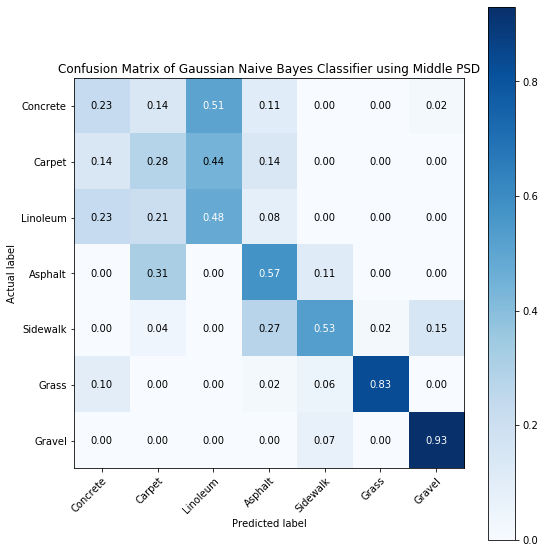

In [101]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

In [102]:
# Try saving all CM images
#save_all_cm(test_vectors, predict_vectors, 'NB')

### Part (b) - k Nearest Neighbour

In [103]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [104]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [105]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD k Nearest Neighbor Classifer: Accuracy = {}'.format(accuracy))

Middle PSD k Nearest Neighbor Classifer: Accuracy = 0.6042780748663101


<Figure size 432x288 with 0 Axes>

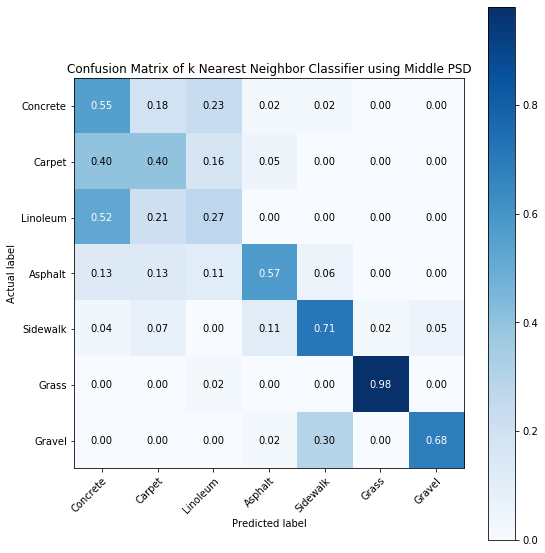

In [106]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of k Nearest Neighbor Classifier using Middle PSD')

### Part (c) - Decision Trees

In [107]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [108]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [109]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat[1]['Middle'], predict_feat['Middle'])
print('Middle PSD Decision Tree Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Decision Tree Classifer: Accuracy = 0.8262032085561497


<Figure size 432x288 with 0 Axes>

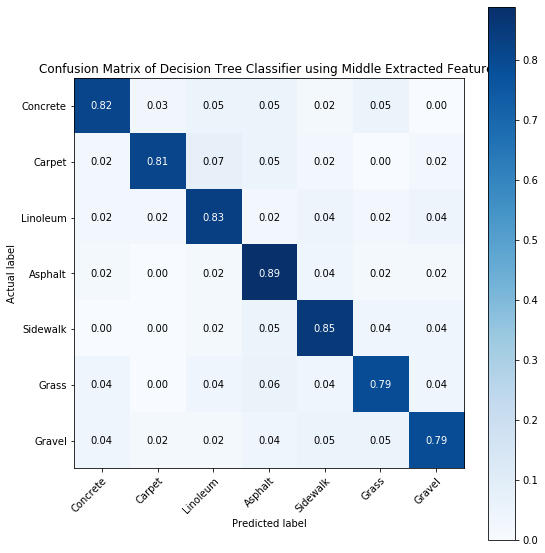

In [110]:
plot_confusion_matrix(test_feat[1]['Middle'], predict_feat['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Decision Tree Classifier using Middle Extracted Features')

### Part (d) - Random Forest 

In [111]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [112]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [113]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD Log Random Forest Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Log Random Forest Classifer: Accuracy = 0.7058823529411765


<Figure size 432x288 with 0 Axes>

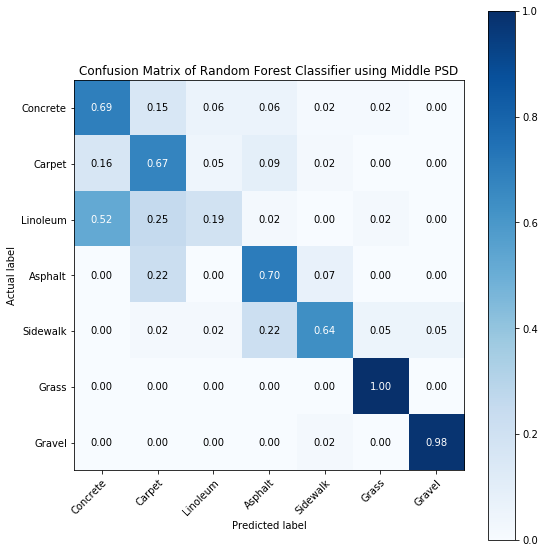

In [114]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Random Forest Classifier using Middle PSD')

### Part (e) - AdaBoost

In [115]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

In [116]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [117]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD Log AdaBoost Classifer: Accuracy = {}'.format(accuracy))

Middle PSD Log AdaBoost Classifer: Accuracy = 0.40641711229946526


<Figure size 432x288 with 0 Axes>

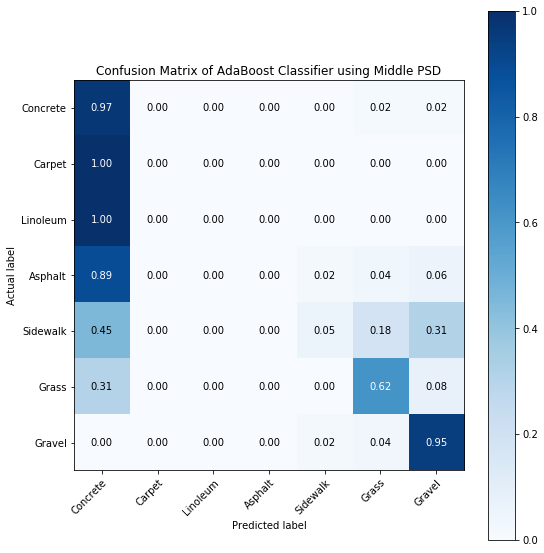

In [118]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of AdaBoost Classifier using Middle PSD')

### Part (f) - SVM (Support Vector Machine)

In [119]:
from sklearn.svm import SVC
model = SVC(gamma='scale')

In [120]:
# Predict for each of our feature vectors
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [121]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

Middle PSD SVM Classifer: Accuracy = 0.7299465240641712


<Figure size 432x288 with 0 Axes>

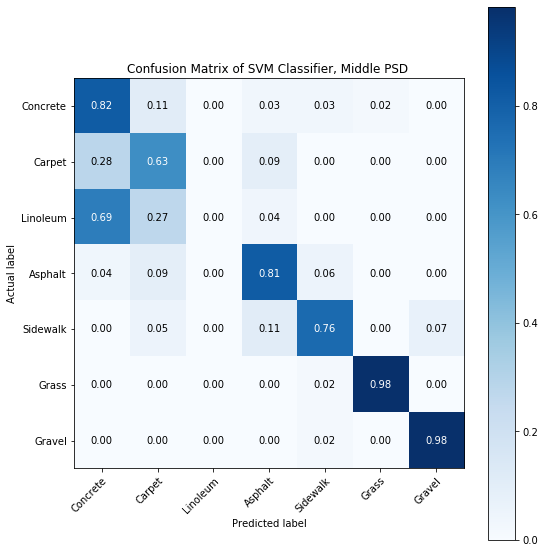

In [122]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle PSD ')

### Part (g) - Create Accuracy Table

In [123]:
# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [124]:
def create_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement for placement in placements for vector in vector_names]
    accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        # Get k fold predict and actual labels for each vector
        feat  = train_test_k_fold(feat_combined, n_splits, model)
        fft = train_test_k_fold(fft_combined, n_splits, model)
        psd_log = train_test_k_fold(psd_log_combined, n_splits, model)
        vectors = (feat, fft, psd_log)

        # Add current axis and classifier to row dictionary
        for placement in placements:
            for i, vector_name in enumerate(vector_names):

                index_name = vector_name + ' ' + placement

                # Extract predicted and actual labels
                predict, actual = vectors[i][placement]

                # Take mean accuracy of k fold testing
                accuracies = []
                for j in range(len(predict)):
                    accuracies.append(accuracy_score(actual[j], predict[j]))
                rows.update({index_name: np.mean(accuracies)})

        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(rows)
    return accuracy_table

In [125]:
# Create accuracy table for 5 splits, Middle only
accuracy_table = create_accuracy_table(5)
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle,0.086717,0.394014,0.807835,0.741955,0.505891,0.441109
1,FFT Middle,0.567451,0.550306,0.550332,0.721625,0.405236,0.676650
2,PSDLog Middle,0.570661,0.626873,0.507472,0.697554,0.376858,0.716249


In [126]:
# Create accuracy table for 10 splits, Middle only
accuracy_table = create_accuracy_table(10)
accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle,0.070097,0.384912,0.821172,0.748384,0.507498,0.453450
1,FFT Middle,0.564795,0.569096,0.557323,0.721623,0.427773,0.692717
2,PSDLog Middle,0.574987,0.635441,0.508605,0.681971,0.405793,0.721086


## Part 10 - Combining Feature Selection with Classifiers

In [127]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [128]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection on Individual Feature Vectors

#### Part (i) - Extracted Features

In [129]:
model = DecisionTreeClassifier()

In [130]:
feat_top_features = extract_top_features(feat_combined, 10)

In [131]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [132]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Middle'], predict_feat_top['Middle'])
print('DT Classifer with Top 10 Middle Extracted Features: Accuracy = {}'.format(accuracy))

DT Classifer with Top 10 Middle Extracted Features: Accuracy = 0.8689839572192514


<Figure size 432x288 with 0 Axes>

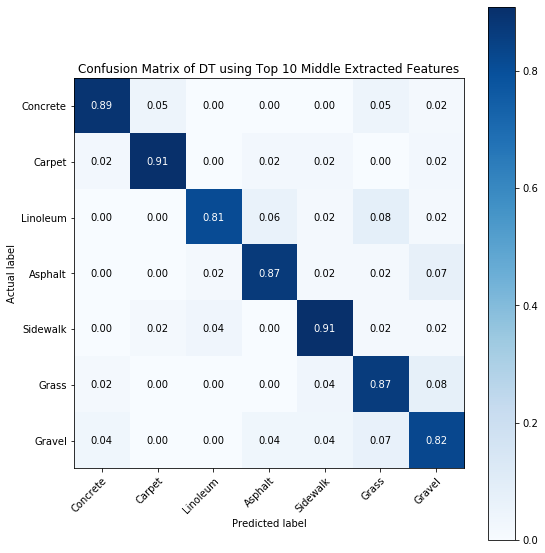

In [133]:
plot_confusion_matrix(test_feat_top[1]['Middle'], predict_feat_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Middle Extracted Features')

#### Part (ii) - FFT

In [134]:
model = SVC(gamma='scale')

In [135]:
fft_top_features = extract_top_features(fft_combined, 20)

In [136]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_placement(train_fft_top, test_fft_top, model)

In [137]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 20 FFT Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 20 FFT Features: Accuracy = 0.5588235294117647


<Figure size 432x288 with 0 Axes>

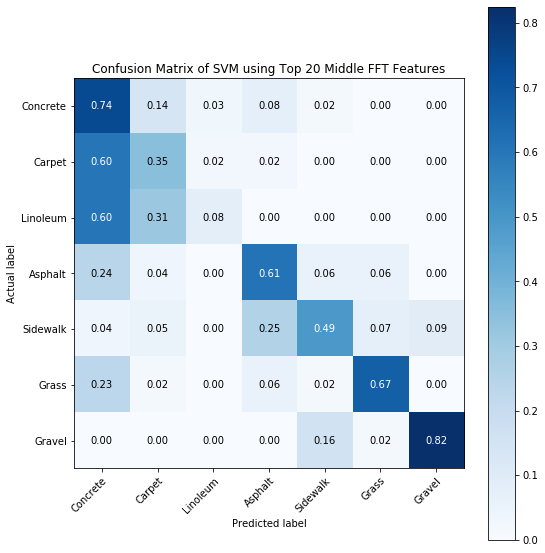

In [138]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle FFT Features')

#### Part (iii) - PSD Log

In [139]:
psd_log_top_features = extract_top_features(psd_log_combined, 20)

In [140]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_placement(train_psd_log_top, test_psd_log_top, model)

In [141]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 20 PSD Features: Accuracy = {}'.format(accuracy))

Middle SVM Classifer with Top 20 PSD Features: Accuracy = 0.6229946524064172


<Figure size 432x288 with 0 Axes>

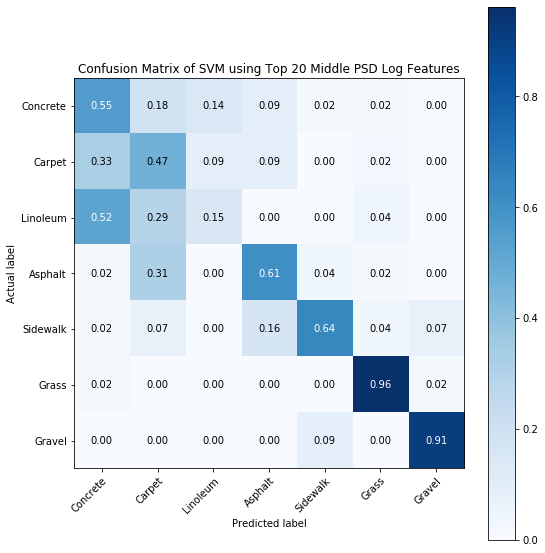

In [142]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle PSD Log Features')

### Part (b) Compute mRMR up to Max Number of Features

In [143]:
feat_top_features = extract_top_features(feat_combined, 90)

In [144]:
feat_top_df = pd.DataFrame(feat_top_features, columns=['Left', 'Middle', 'Right'])
feat_top_df.head()

,Left,Middle,Right
0,NaN,Excess Kurtosis Y Accel Middle,NaN
1,NaN,Mean Square Frequency Z Gyro Middle,NaN
2,NaN,Autocorrelation Y Gyro Middle,NaN
3,NaN,Excess Kurtosis X Gyro Middle,NaN
4,NaN,Zero Crossing Rate Z Gyro Middle,NaN


In [172]:
# Save to .csv for easy access
feat_top_df.to_csv('processed_data/Top_Features_Filt.csv')

In [146]:
fft_top_features = extract_top_features(fft_combined, 240)

In [147]:
fft_top_df = pd.DataFrame(fft_top_features, columns=['Left', 'Middle', 'Right'])
fft_top_df.head()

,Left,Middle,Right
0,NaN,FFT 29.0 Hz Z Accel Middle,NaN
1,NaN,FFT 24.0 Hz Z Accel Middle,NaN
2,NaN,FFT 30.0 Hz Z Accel Middle,NaN
3,NaN,FFT 28.0 Hz Z Accel Middle,NaN
4,NaN,FFT 0.0 Hz Y Accel Middle,NaN


In [173]:
fft_top_df.to_csv('processed_data/Top_FFTs_Filt.csv')

In [149]:
psd_log_top_features = extract_top_features(psd_log_combined, 240)

In [150]:
psd_log_top_df = pd.DataFrame(psd_log_top_features, columns=['Left', 'Middle', 'Right'])
psd_log_top_df.head()

,Left,Middle,Right
0,NaN,PSDLog 31.0 Hz Y Gyro Middle,NaN
1,NaN,PSDLog 0.0 Hz Y Gyro Middle,NaN
2,NaN,PSDLog 11.0 Hz Y Gyro Middle,NaN
3,NaN,PSDLog 13.0 Hz Y Gyro Middle,NaN
4,NaN,PSDLog 30.0 Hz Y Gyro Middle,NaN


In [174]:
psd_log_top_df.to_csv('processed_data/Top_PSDs_Filt.csv')

### Part (c) - Compare Top Features to Classification Accuracy

In [152]:
def subset_top(top_features, n_top):
    subset_top_features = {}
    
    for placement, features in top_features.items():
        n_features = features[0:n_top - 1]
        # Add label to ensure it remains with the data
        if 'Label' not in n_features:
            n_features.append('Label')
        
        subset_top_features.update({placement: n_features})
        
    return subset_top_features

In [153]:
def train_n_feats(combined, top_features):
    n_feats_arr = np.arange(5, len(top_features['Middle']), 5)
    accuracies = {'Middle': []}

    # Train and test for each number of top features
    for n_feat in n_feats_arr:
        
        combined_top = top_features_only(combined, subset_top(top_features, n_feat))
        # Get k fold predict and actual labels for each vector
        feature = train_test_k_fold(combined_top, 5, model)
        
        # Compare accuracies vs top features
        for placement in test_feat_top[1].keys():
            # Extract predict and actual
            predict, actual = feature[placement]
            
            # Take mean accuracy of k fold testing
            accuracy_k_fold = []
            
            for i in range(len(predict)):
                accuracy_k_fold.append(accuracy_score(actual[i], predict[i]))
            
            accuracies[placement].append(np.mean(accuracy_k_fold))

    return n_feats_arr, accuracies

#### Part (i) - Compare Feature Vectors of each Placement for Same Classifier

In [154]:
model = DecisionTreeClassifier()

In [155]:
feat_n_features, feat_accuracies = train_n_feats(feat_combined, feat_top_features)

In [156]:
fft_n_features, fft_accuracies = train_n_feats(fft_combined, fft_top_features)

In [157]:
psd_log_n_features, psd_log_accuracies = train_n_feats(psd_log_combined, psd_log_top_features)

In [158]:
def plot_n_features_accuracy(n_features, accuracies, feat_name=None, classifier_name=None):
    plt.clf()
    plt.figure(figsize=(8, 6))
    
    for placement, accuracy in accuracies.items():
        plt.plot(n_features, accuracy, label=placement)
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Top Features Used')
    plt.title('Accuracy vs Top ' + feat_name + ', Classifier = ' + classifier_name)
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

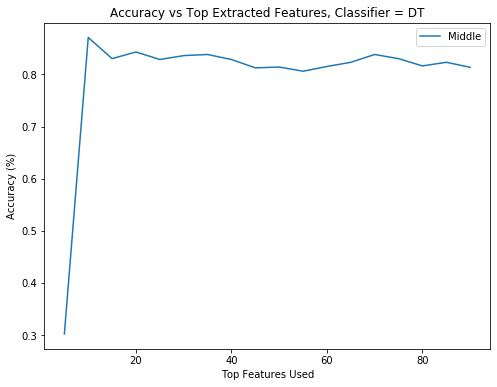

In [159]:
plot_n_features_accuracy(feat_n_features, feat_accuracies, 'Extracted Features', 'DT')

#### Part (ii) - Compare Classifiers for Same Placement and Feature Vector

In [160]:
# Dictionary of accuracy vs number of features for each classifier
classifiers_n_features = {}

In [161]:
for classifier_name, classifier in classifiers.items():
    feat = train_n_feats(feat_combined, feat_top_features)
    fft = train_n_feats(fft_combined, fft_top_features)
    psd_log = train_n_feats(psd_log_combined, psd_log_top_features)
    
    classifiers_n_features.update({classifier_name: (feat, fft, psd_log)})

In [162]:
def plot_classifiers_vs_n_features(vector_num, placement):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    for class_name, class_vectors  in classifiers_n_features.items():
        (n_features, accuracy) = class_vectors[vector_num]
        
        # If we want to plot all the placements
        if placement == 'All':
            for _placement in placements:
                if _placement in accuracy.keys():
                    plt.plot(n_features, accuracy[_placement], label=class_name + ' ' + _placement)
        else:
            plt.plot(n_features, accuracy[placement], label=class_name)
            
    
    plt.xlabel('Top Features Used')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Top Features for ' + placement + ' ' + vector_names[vector_num])
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

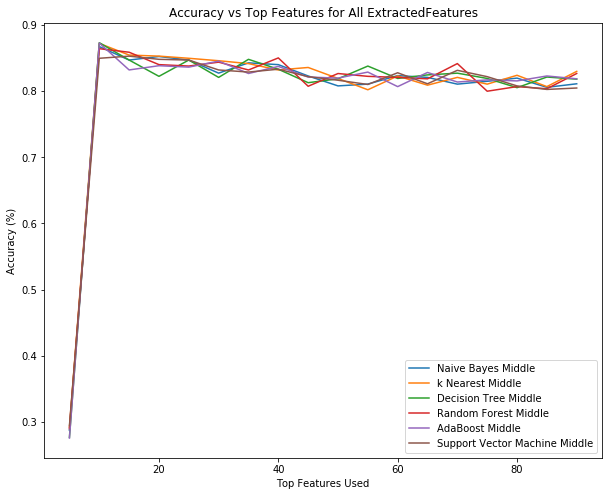

In [163]:
plot_classifiers_vs_n_features(0, 'All')

<Figure size 432x288 with 0 Axes>

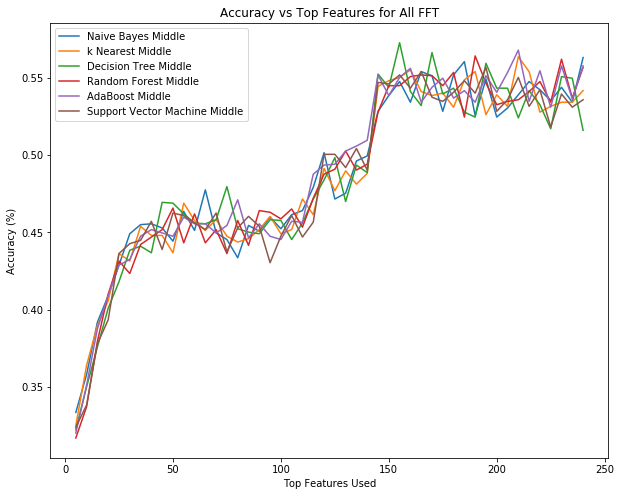

In [164]:
plot_classifiers_vs_n_features(1, 'All')

<Figure size 432x288 with 0 Axes>

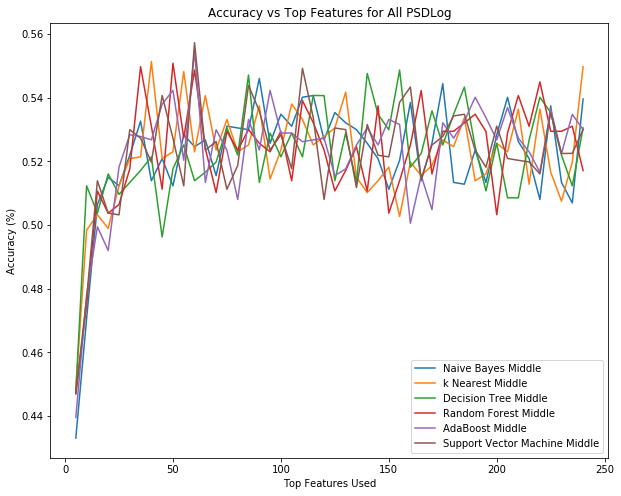

In [165]:
plot_classifiers_vs_n_features(2, 'All')

Important to note that X Accel and Y accel of the wheels are virtually the same since their direction changes as the wheel rotates

## Part 11 - Classification on Single Axes

### Part (a) - Separate Combined Data

In [166]:
'''Get placement dictionary of combined data truncated to only include columns matching given tag'''
def get_matching_columns(combined_data, column_match):
    # New placement dictionary with only matching columns
    combined_matching_data = {}
    
    for placement, placement_data in combined_data.items():
        # Retrieve column names that match the given match parameter
        matching_columns = [column for column in placement_data.columns if column_match in column]
        matching_columns.append('Label')
        combined_matching_data.update({placement: placement_data[matching_columns]})
        
    return combined_matching_data

In [167]:
'''Separate combined dataframe into dictionary of axes columns'''
def separate_combined(combined_data):
    separated_data = {}
    
    for axes_column in data_columns:
        separated_data.update({axes_column: get_matching_columns(combined_data, axes_column)})
        
    return separated_data

In [168]:
feat_separated = separate_combined(feat_combined)
fft_separated = separate_combined(fft_combined)
psd_log_separated = separate_combined(psd_log_combined)

feat_separated['Z Accel']['Middle'].head()

,Mean Z Accel Middle,Std Dev Z Accel Middle,L2 Norm Z Accel Middle,Autocorrelation Z Accel Middle,Max Z Accel Middle,Min Z Accel Middle,Root Mean Squared Z Accel Middle,Zero Crossing Rate Z Accel Middle,Skew Z Accel Middle,Excess Kurtosis Z Accel Middle,Mean Square Frequency Z Accel Middle,Root Mean Square Frequency Z Accel Middle,Frequency Center Z Accel Middle,Variance Frequency Z Accel Middle,Root Variance Frequency Z Accel Middle,Label
0,2.792249,2.835498,2.838865,4.191820,2.926731,-3.050949,2.838865,0.181872,-0.711415,-0.511041,3.820216,2.697818,-0.177012,0.407180,2.697818,5
1,-2.196335,0.964134,0.967285,0.866905,0.317590,-0.977637,0.967285,1.214644,-0.252924,-0.714602,0.355003,0.604822,0.265602,-0.192539,0.604822,5
2,-0.192109,0.326828,0.325788,0.093721,0.607698,-0.319773,0.325788,-0.850901,0.114098,-0.193574,0.254064,0.514652,-0.843811,0.854170,0.514652,5
3,0.549800,-1.618046,-1.619821,-1.107110,-1.514982,1.669655,-1.619821,0.181872,1.777015,0.710547,-0.949170,-1.417517,1.769758,-1.894672,-1.417517,5
4,-0.113844,-1.224213,-1.226182,-1.003024,-1.539189,1.378818,-1.226182,0.526129,-0.265930,-0.810367,-0.887869,-1.135588,0.428312,-0.416916,-1.135588,5


### Part (b) - Compute Accuracy Table for Single Axes

In [169]:
def create_axes_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement + ' ' + axis for axis in data_columns for placement in placements for vector in vector_names]
    axes_accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each axes of each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        for axis in data_columns:
            # Get k fold predict and actual labels for each vector for current axis
            feat  = train_test_k_fold(feat_separated[axis], n_splits, model)
            fft = train_test_k_fold(fft_separated[axis], n_splits, model)
            psd_log = train_test_k_fold(psd_log_separated[axis], n_splits, model)
            vectors = (feat, fft, psd_log)

            # Add current axis and classifier to row dictionary
            for i, vector_name in enumerate(vector_names):
                for placement in placements:
                    index_name = vector_name + ' ' + placement + ' ' + axis

                    # Extract predicted and actual labels
                    predict, actual = vectors[i][placement]

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for j in range(len(predict)):
                        accuracies.append(accuracy_score(actual[j], predict[j]))
                    rows.update({index_name: np.mean(accuracies)})

            # Update accuracy table with classifier column by mapping row names to indices
            axes_accuracy_table[classifier_name] = axes_accuracy_table['Vector'].map(rows)
    
    return axes_accuracy_table

In [170]:
axes_accuracy_table = create_axes_accuracy_table(5)

In [171]:
axes_accuracy_table

,Vector,Naive Bayes,k Nearest,Decision Tree,Random Forest,AdaBoost,Support Vector Machine
0,ExtractedFeatures Middle X Accel,0.123128,0.258018,0.312641,0.379020,0.249475,0.298178
1,FFT Middle X Accel,0.436847,0.398822,0.366180,0.534248,0.361892,0.525697
2,PSDLog Middle X Accel,0.443783,0.319572,0.358120,0.522489,0.332427,0.515534
3,ExtractedFeatures Middle Y Accel,0.109210,0.333513,0.392919,0.505358,0.294958,0.389204
4,FFT Middle Y Accel,0.528921,0.470557,0.434147,0.623121,0.334040,0.612451
5,PSDLog Middle Y Accel,0.547143,0.480736,0.437367,0.627419,0.328652,0.622043
6,ExtractedFeatures Middle Z Accel,0.123646,0.270342,0.349559,0.443245,0.283192,0.330296
7,FFT Middle Z Accel,0.541747,0.562082,0.484989,0.678263,0.369358,0.617240
8,PSDLog Middle Z Accel,0.550313,0.509052,0.472699,0.638669,0.391322,0.631139
9,ExtractedFeatures Middle X Gyro,0.097946,0.308877,0.279458,0.406322,0.234496,0.343168


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right